In [1]:
# Package
from __future__ import print_function  
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from tqdm import tqdm_notebook as tqdm
# from mpi4py import MPI
import time
import os 
import glob
from argparse import ArgumentParser
from gridSearch import *
from mnist_utils import *
import numpy as np
import random
from hyperparams import *

In [2]:
def get_best_acc(resultDict):
    best_acc = 0.0
    for hparams, acc in resultDict.items():
        if acc > best_acc:
            best_acc = acc
    return best_acc

In [3]:
MASTER_RANK = 0
mpiWorld = None
device = torch.device("cuda:1")

In [4]:
# REPRODUCIBILITY
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# === Init Search Space === #
lr = DRV(choices=[(i/100) for i in range(10, 100+1, 10)], name="lr")
dr = DRV(choices=[(i/100) for i in range(10, 100+1, 10)], name="dr")
# mmt = DRV(choices=[(i/10) for i in range(1, 10+1)], name="momentum")
# bs = DRV(choices=[16, 32, 64, 128, 256], name="bs")

hparams = HyperParams([lr, dr])
grid = Grid(hparams)
print(grid)

=== Grid ===
lr:[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dr:[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



In [6]:
pbars = {"search":tqdm(ncols=800, total=len(grid), unit='search'), 
         "train":tqdm(ncols=1000), 
         "test":tqdm(ncols=1000)}
pbars['search'].set_description("Grid Search")

resultDict = {}
for i in range(len(grid)):
    lr, dr = grid[i]
    acc = train_mnist(lr=lr, mmt=dr, device=device, pbars=pbars)
    grid[i] = acc
    resultDict[(lr, dr)] = acc
    pbars['search'].set_postfix({"Best":get_best_acc(resultDict)})
    pbars['search'].update()

=== Grid Search Result ===
      ||  0.10  |  0.20  |  0.30  |  0.40  |  0.50  |  0.60  |  0.70  |  0.80  |  0.90  |  1.00  |
0.10  || 92.34  | 88.07  | 89.38  | 91.66  | 84.43  | 88.05  | 85.00  | 85.85  | 20.99  | 10.09  |
0.20  || 90.47  | 90.18  | 83.17  | 14.75  | 86.27  | 88.62  | 84.13  | 11.63  |  9.58  | 11.35  |
0.30  || 90.14  | 10.28  | 10.28  | 21.58  | 10.28  | 25.90  | 10.28  | 10.28  | 10.28  |  9.82  |
0.40  || 11.25  | 78.13  | 81.28  | 79.62  | 10.28  | 55.73  | 10.28  |  9.58  | 10.32  | 11.35  |
0.50  || 10.30  | 10.28  | 26.14  | 24.20  | 10.28  |  9.58  |  9.58  | 29.52  | 10.32  | 10.09  |
0.60  || 10.28  | 31.31  | 10.28  | 10.28  |  9.58  |  9.58  |  9.58  | 10.32  | 10.22  |  9.74  |
0.70  || 10.28  |  9.58  |  9.58  |  9.58  |  9.58  |  9.58  |  9.58  |  9.58  |  9.58  | 10.10  |
0.80  ||  9.58  |  9.58  |  9.58  |  9.58  |  9.58  |  9.58  |  9.58  |  9.58  |  9.58  |  9.80  |
0.90  ||  9.58  |  9.58  |  9.57  |  9.58  |  9.58  |  9.58  |  9.58  |  9.58  |  

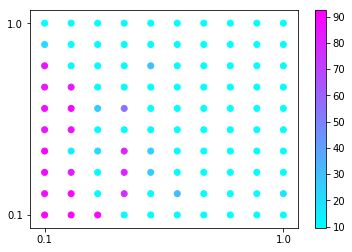

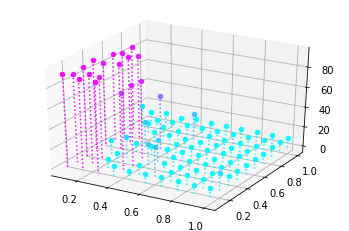

In [7]:
print("=== Grid Search Result ===")
grid.print2DGrid()
hyperparams = []
results = []
for (lr, dr), acc in resultDict.items():
    hyperparams.append((lr, dr))
    results.append(acc)
vis_search(hyperparams, results)